In [1]:
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat

In [2]:
# Load the CSV file
quality_df = pd.read_csv('Data_Quality_Evaluation.csv', index_col=0)

# Transpose the DataFrame
quality_df = quality_df.T

In [3]:
# Define EEG channels
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Function to extract all channels from a .mat file
def get_all_channels_from_mat(file_path):
    """
    Load a .mat file and extract all channels as a NumPy array.
    Returns a 8xTime NumPy array where each row is a channel.
    Returns None if file doesn't exist or has issues.
    """
    try:
        mat_data = loadmat(file_path)
        
        # Use 'ThisEEG' as the data key
        data_key = 'ThisEEG'
        
        if data_key not in mat_data:
            print(f"Warning: 'ThisEEG' key not found in {file_path}")
            return None
        
        # Assume the data is already in 8xTime format
        data_array = mat_data[data_key]
        
        # Return as NumPy array with shape (8, time_points)
        return np.array(data_array, dtype=np.float64)
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [4]:
# Build the main DataFrame
# Participants: 1 to 58 (as strings to match quality_df)
# Video clips: 1 to 36

participants = [str(i) for i in range(1, 59)]  # "1" to "58" as strings
video_clips = list(range(1, 37))  # 1 to 36

# Initialize DataFrame with object dtype to store NumPy arrays
eeg_df = pd.DataFrame(index=participants, columns=video_clips, dtype=object)

# Fill the DataFrame
for participant in participants:
    # Convert participant string to P01 format for folder name
    participant_folder = f"P{int(participant):02d}"
    
    for video_id in video_clips:
        file_path = f'EEGData/Movie_{participant_folder}/EEG_Clip{video_id}.mat'
        
        # Get all channels as a NumPy array (8xTime)
        eeg_array = get_all_channels_from_mat(file_path)
        
        if eeg_array is not None:
            eeg_df.at[participant, video_id] = eeg_array
        else:
            eeg_df.at[participant, video_id] = None

In [5]:
# Create cleaned DataFrame based on quality scores
# 1 = perfect, 2 = good, 3 = ok, 4 = problematic, 5 = bad, 6 = missing
# Remove all data with quality score => 3

# Start with a copy of eeg_df
eeg_cleaned_df = eeg_df.copy()

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        # Check if quality score exists and is > 3
        if participant in quality_df.index and video_id in quality_df.columns:
            quality_score = quality_df.loc[participant, video_id]
            if pd.notna(quality_score) and quality_score > 3:
                # Set the corresponding EEG data to None
                eeg_cleaned_df.at[participant, video_id] = None

In [6]:
from antropy import lziv_complexity

def calculate_lzc(signal, hz=32, epoch_len_sec=2.0):
    """
    signal: array of shape (1, samples) or (samples,)
    hz: sampling rate
    epoch_len_sec: length of epoch to calculate LPZ over
    
    Returns: average Lempel-Ziv complexity across all epochs
    """
    # Ensure signal is 1D
    if len(signal.shape) == 2:
        signal = signal.flatten()
    
    n_samples = len(signal)
    epoch_samples = int(hz * epoch_len_sec)  # number of samples per epoch
    n_epochs = n_samples // epoch_samples  # number of complete epochs
    
    if n_epochs == 0:
        return np.nan
    
    lzc_vals = []
    
    # Calculate LZC for each epoch
    for e in range(n_epochs):
        # Extract epoch
        start_idx = e * epoch_samples
        end_idx = start_idx + epoch_samples
        epoch = signal[start_idx:end_idx]
        
        # Z-score the epoch
        z_scored = (epoch - np.mean(epoch)) / (np.std(epoch) + 1e-9)
        
        # Binarize (threshold at 0)
        binarized = (z_scored > 0).astype(int)
        
        # Calculate Lempel-Ziv complexity
        lzc = lziv_complexity(binarized)
        lzc_vals.append(lzc)
    
    # Return average LZC across all epochs
    return np.mean(lzc_vals)

In [7]:
# Calculate LZC for all cells in eeg_cleaned_df
# Create a new DataFrame with the same shape
lzc_df = pd.DataFrame(index=eeg_cleaned_df.index, columns=eeg_cleaned_df.columns, dtype=object)

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        eeg_data = eeg_cleaned_df.at[participant, video_id]
        
        # If the cell is None, keep it None
        if eeg_data is None:
            lzc_df.at[participant, video_id] = None
        else:
            # eeg_data is an 8xTime NumPy array
            # Calculate LZC for each of the 8 channels
            lzc_values = []
            
            for channel_idx in range(8):
                # Extract the channel data (one row from the 8xTime array)
                channel_signal = eeg_data[channel_idx, :]
                
                # Calculate LZC for this channel
                lzc = calculate_lzc(channel_signal, hz=32, epoch_len_sec=2.0)
                lzc_values.append(lzc)
            
            # Store as NumPy array (NaN values will be preserved)
            lzc_df.at[participant, video_id] = np.array(lzc_values, dtype=np.float64)

In [8]:
# Count the number of non-None cells for each participant
valid_trial_counts = lzc_df.notna().sum(axis=1)
valid_trial_counts_dict = valid_trial_counts.to_dict()

# Make a list of participants with less than 3 valid trials
participants_with_less_than_3_valid_trials = [participant for participant, count in valid_trial_counts_dict.items() if count < 3]

# Filter out rows with participants with less than 3 valid trials
lzc_filtered_df = lzc_df[~lzc_df.index.isin(participants_with_less_than_3_valid_trials)]

# Filter to participants 1-36 (as strings)
participants_1_to_36 = [str(i) for i in range(1, 37)]
lzc_filtered_df = lzc_filtered_df[lzc_filtered_df.index.isin(participants_1_to_36)]

lzc_filtered_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[8.0, 3.0588235294117645, 3.1176470588235294, ...","[8.363636363636363, 2.878787878787879, 2.84848...","[8.666666666666666, 3.4444444444444446, 3.2592...",None,"[8.9, 3.32, 3.22, 2.8, 2.62, 3.34, 3.14, 3.16]",None,"[7.177777777777778, 2.2, 2.2444444444444445, 2...",None,"[8.571428571428571, 3.2285714285714286, 3.3142...",None,...,None,"[8.295454545454545, 3.3863636363636362, 3.4545...","[8.186046511627907, 2.883720930232558, 2.67441...",None,"[7.140625, 2.84375, 2.828125, 2.828125, 2.8281...",None,"[8.793103448275861, 3.3275862068965516, 3.4655...","[8.6, 3.1333333333333333, 3.2333333333333334, ...",None,"[8.35483870967742, 3.0, 3.032258064516129, 3.0..."
2,"[8.176470588235293, 3.235294117647059, 3.21568...",None,None,"[8.261904761904763, 3.1666666666666665, 3.3333...","[8.46, 3.18, 3.24, 3.06, 3.08, 3.02, 3.02, 3.06]",None,"[8.355555555555556, 3.4, 3.2666666666666666, 2...","[8.242424242424242, 3.1818181818181817, 3.0909...","[8.714285714285714, 3.2, 3.1142857142857143, 3...","[8.222222222222221, 3.0444444444444443, 3.1777...",...,"[8.17142857142857, 3.0285714285714285, 3.14285...","[8.318181818181818, 3.1363636363636362, 3.2727...","[8.767441860465116, 3.3255813953488373, 3.2790...","[8.256410256410257, 2.8461538461538463, 2.6923...","[8.640625, 3.171875, 3.265625, 3.21875, 3.1406...","[8.185185185185185, 3.1481481481481484, 3.1481...","[8.551724137931034, 3.3448275862068964, 3.2758...","[7.9, 3.0, 2.9, 3.066666666666667, 3.033333333...","[8.444444444444445, 3.1555555555555554, 3.2, 3...","[8.387096774193548, 3.161290322580645, 3.29032..."
3,"[8.509803921568627, 3.176470588235294, 3.29411...","[8.606060606060606, 3.121212121212121, 3.30303...","[8.814814814814815, 3.3333333333333335, 3.1481...","[7.857142857142857, 3.261904761904762, 3.33333...","[7.12, 3.28, 3.16, 3.08, 3.18, 3.16, 3.18, 3.08]","[7.0, 3.423076923076923, 3.3076923076923075, 3...","[7.2, 3.2888888888888888, 3.3333333333333335, ...","[8.181818181818182, 3.272727272727273, 3.36363...","[7.085714285714285, 3.085714285714286, 3.14285...","[8.11111111111111, 3.2444444444444445, 3.15555...",...,"[8.6, 3.3142857142857145, 3.2285714285714286, ...",None,"[7.744186046511628, 3.186046511627907, 3.34883...","[8.564102564102564, 3.1538461538461537, 3.3589...","[8.234375, 3.265625, 3.390625, 3.21875, 3.2031...","[8.11111111111111, 3.259259259259259, 3.148148...","[8.53448275862069, 3.2758620689655173, 3.29310...","[8.466666666666667, 3.2333333333333334, 3.4, 3...","[7.688888888888889, 3.022222222222222, 3.15555...","[7.645161290322581, 3.129032258064516, 3.06451..."
4,"[7.8431372549019605, 3.2941176470588234, 3.254...","[8.242424242424242, 3.212121212121212, 3.12121...","[7.962962962962963, 3.4074074074074074, 3.2592...","[7.738095238095238, 3.119047619047619, 3.16666...","[7.46, 3.36, 3.22, 3.18, 3.22, 3.12, 3.2, 3.06]","[7.8076923076923075, 3.076923076923077, 3.1923...","[7.111111111111111, 3.066666666666667, 3.02222...","[7.878787878787879, 3.272727272727273, 3.42424...","[7.942857142857143, 3.2857142857142856, 3.1142...","[8.177777777777777, 3.2444444444444445, 3.2888...",...,"[8.0, 2.6285714285714286, 3.342857142857143, 2...","[8.204545454545455, 3.2954545454545454, 3.4318...","[7.744186046511628, 3.395348837209302, 3.37209...","[8.076923076923077, 3.3846153846153846, 3.4358...","[7.890625, 2.6875, 2.609375, 2.96875, 2.921875...","[8.25925925925926, 3.2962962962962963, 3.37037...","[7.224137931034483, 2.7758620689655173, 2.7413...","[7.233333333333333, 3.3, 3.1666666666666665, 3...","[8.28888888888889, 3.2, 3.2888888888888888, 2....",None
5,None,None,None,"[5.9523809523809526, 3.1666666666666665, 3.238...","[5.88, 2.28, 2.26, 2.24, 2.28, 2.28, 2.18, 2.32]",None,None,None,None,None,...,None,"[7.681818181818182, 2.909090909090909, 2.86363...",None,"[8.0, 2.923076923076923, 2.8205128205128207, 2...","[7.140625, 2.890625, 2.84375, 2.9375, 2.84375,...","[8.407407407407407, 2.814814814814815, 2.75925...","[8.5, 3.05

In [9]:
# Load Arousal.csv
# First column as row indices, first row as column labels
arousal_df = pd.read_csv('Arousal.csv', index_col=0, header=0)
arousal_df = arousal_df.T

In [10]:
# Create arousal_filtered_df by filtering arousal_df based on lzc_filtered_df
# Wherever lzc_filtered_df has None, set the corresponding cell in arousal_filtered_df to NaN

# Convert index to strings to match lzc_filtered_df
arousal_df.index = arousal_df.index.astype(str)

# Filter to only include participants that are in lzc_filtered_df
matching_participants = arousal_df.index.intersection(lzc_filtered_df.index)
arousal_filtered_df = arousal_df.loc[matching_participants].copy()

# Ensure columns are 1-36 (video clips) and in the same order
arousal_filtered_df = arousal_filtered_df.reindex(columns=range(1, 37))

# Now, for each cell where lzc_filtered_df has None, set the corresponding cell to NaN
for participant in arousal_filtered_df.index:
    for video_id in arousal_filtered_df.columns:
        # Check if lzc_filtered_df has None at this position
        if participant in lzc_filtered_df.index and video_id in lzc_filtered_df.columns:
            lzc_value = lzc_filtered_df.at[participant, video_id]
            if lzc_value is None:
                arousal_filtered_df.at[participant, video_id] = np.nan

In [11]:
# Create a combined dataframe with all data needed for analysis
# Columns: Participant_ID, Video_ID, Arousal, and 8 LZC channel scores (NO Valence)

# Initialize list to store rows
rows = []

# Iterate through all participant/video combinations in lzc_filtered_df
for participant in lzc_filtered_df.index:
    for video_id in lzc_filtered_df.columns:
        # Get LZC array for this trial
        lzc_array = lzc_filtered_df.at[participant, video_id]
        
        # Skip if None
        if lzc_array is None:
            continue
        
        # Initialize row dictionary
        row = {
            'Participant_ID': participant,
            'Video_ID': video_id
        }
        
        # Get Arousal from arousal_filtered_df
        if participant in arousal_filtered_df.index and video_id in arousal_filtered_df.columns:
            arousal_val = arousal_filtered_df.at[participant, video_id]
            row['Arousal'] = arousal_val if not np.isnan(arousal_val) else np.nan
        else:
            row['Arousal'] = np.nan
        
        # Get LZC scores for each channel
        if isinstance(lzc_array, np.ndarray) and len(lzc_array) == 8:
            for channel_idx, channel_name in enumerate(channels):
                lzc_val = lzc_array[channel_idx]
                row[channel_name] = lzc_val if not np.isnan(lzc_val) else np.nan
        else:
            # If array is not valid, set all channels to NaN
            for channel_name in channels:
                row[channel_name] = np.nan
        
        # Add row to list
        rows.append(row)

# Create DataFrame from list of rows
combined_df = pd.DataFrame(rows)

# Reorder columns: Participant_ID, Video_ID, Arousal, then 8 channels (NO Valence)
column_order = ['Participant_ID', 'Video_ID', 'Arousal'] + channels
combined_df = combined_df[column_order]


In [12]:
# Create the mean columns as the mean of alpha 1/2, beta1/2, gamma1/2 for each row (trial)
combined_df['alpha_mean'] = combined_df[['alpha1', 'alpha2']].mean(axis=1)
combined_df['beta_mean'] = combined_df[['beta1', 'beta2']].mean(axis=1)
combined_df['gamma_mean'] = combined_df[['gamma1', 'gamma2']].mean(axis=1)

combined_df

,Participant_ID,Video_ID,Arousal,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,alpha_mean,beta_mean,gamma_mean
0,1,1,1.0,8.000000,3.058824,3.117647,3.117647,2.960784,3.117647,3.058824,3.156863,3.117647,3.039216,3.107843
1,1,2,3.0,8.363636,2.878788,2.848485,3.060606,3.030303,2.757576,3.030303,3.000000,2.954545,2.893939,3.015152
2,1,3,1.0,8.666667,3.444444,3.259259,3.148148,3.296296,2.962963,3.185185,3.074074,3.203704,3.129630,3.129630
3,1,5,4.0,8.900000,3.320000,3.220000,2.800000,2.620000,3.340000,3.140000,3.160000,3.010000,2.980000,3.150000
4,1,7,3.0,7.177778,2.200000,2.244444,2.466667,2.555556,2.777778,2.422222,2.777778,2.355556,2.666667,2.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,36,32,4.0,8.851852,2.000000,3.259259,3.407407,3.222222,3.370370,3.129630,3.351852,3.333333,3.296296,3.240741
861,36,33,5.0,8.620690,2.000000,3.362069,3.293103,2.948276,3.051724,3.051724,3.034483,3.327586,3.000000,3.043103
862,36,34,5.0,8.733333,2.000000,3.233333,3.233333,3.266667,3.300000,3.066667,2.600000,3.233333,3.283333,2.833333
863,36,35,4.0,8.622222,2.000000,3.266667,3.355556,3.111111,3.133333,2.755556,3.088889,3.311111,3.122222,2.922222


In [13]:
import statsmodels.formula.api as smf

bands = channels + ['alpha_mean', 'beta_mean', 'gamma_mean']

results = []

for band in bands:
    outcome = "Arousal"
    # Keep only the columns we need for this model
    model_df = combined_df[["Participant_ID", "Video_ID", outcome, band]].copy()
    model_df = model_df.dropna(subset=[outcome, band])
    
    if model_df.empty:
        continue
    
    # Formula: Outcome ~ band + C(Video_ID)
    formula = f"{outcome} ~ {band} + C(Video_ID)"
    
    # Mixed model: random intercept for Participant_ID
    model = smf.mixedlm(formula, data=model_df, groups=model_df["Participant_ID"])
    result = model.fit(reml=False)  # reml=True is default; OK for comparing effects
    
    # Extract the band coefficient info
    coef = result.params[band]
    se = result.bse[band]
    p = result.pvalues[band]
    
    # Store in results list
    results.append({
        "Band": band,
        "Outcome": outcome,
        "Grouping": "Participant_ID (random) + Video_ID (fixed)",
        "Coefficient": coef,
        "SE": se,
        "P-value": p,
        "N": len(model_df),
        "AIC": result.aic,
        "BIC": result.bic
    })

# Turn into a nice summary DataFrame
results_df = pd.DataFrame(results)

results_df

,Band,Outcome,Grouping,Coefficient,SE,P-value,N,AIC,BIC
0,delta,Arousal,Participant_ID (random) + Video_ID (fixed),0.017838,0.095623,0.852017,865,2803.828974,2989.575425
1,theta,Arousal,Participant_ID (random) + Video_ID (fixed),-0.094697,0.172308,0.582607,865,2803.561299,2989.307750
2,alpha1,Arousal,Participant_ID (random) + Video_ID (fixed),0.004364,0.199172,0.982519,865,2803.863294,2989.609744
3,alpha2,Arousal,Participant_ID (random) + Video_ID (fixed),0.117303,0.220503,0.594740,865,2803.580817,2989.327268
4,beta1,Arousal,Participant_ID (random) + Video_ID (fixed),0.200630,0.190783,0.292979,865,2802.758199,2988.504650
5,beta2,Arousal,Participant_ID (random) + Video_ID (fixed),0.003862,0.225971,0.986364,865,2803.863481,2989.609932
6,gamma1,Arousal,Participant_ID (random) + Video_ID (fixed),0.223531,0.212644,0.293167,865,2802.757334,2988.503785
7,gamma2,Arousal,Participant_ID (random) + Video_ID (fixed),0.088246,0.320838,0.783279,865,2803.788124,2989.534575
8,alpha_mean,Arousal,Participant_ID (random) + Video_ID (fixed),0.084560,0.258948,0.744006,865,2803.757144,2989.503595
9,beta_mean,Arousal,Participant_ID (random) + Video_ID (fixed),0.199824,0.267426,0.454934,865,2803.305681,2989.052132


In [14]:
# Aggregation dictionary for all target columns
agg_dict = {
    "Arousal": lambda x: np.nan,  # placeholder, will fill below
    "Participant_ID": "nunique",  # how many people rated each video
}
for band in bands:
    agg_dict[band] = lambda x: np.nan

def remove_outliers_and_mean(series, z_thresh=2.5):
    vals = series.dropna()
    if len(vals) == 0:
        return np.nan
    z = np.abs((vals - vals.mean()) / vals.std(ddof=0))
    filtered = vals[z <= z_thresh]
    if len(filtered) == 0:
        return np.nan
    return filtered.mean()

agg_dict["Arousal"] = remove_outliers_and_mean
for band in bands:
    agg_dict[band] = remove_outliers_and_mean

combined_per_video_df = combined_df.groupby("Video_ID").agg(agg_dict).reset_index()

# Rename columns for clarity
combined_per_video_df = combined_per_video_df.rename(columns={
    "Arousal": "Arousal_mean",
    "Participant_ID": "N_participants"
})

In [15]:
from scipy.stats import pearsonr

corr_results = []

for band in bands:
    # Now: Predict lzc from arousal/valence, i.e., lzc ~ arousal_mean
    r, p = pearsonr(combined_per_video_df["Arousal_mean"], combined_per_video_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Arousal_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })


corr_df = pd.DataFrame(corr_results)
corr_df

,Band,Predictor,Outcome,Pearson_r,P_value
0,delta,Arousal_mean,delta,-0.128213,0.456143
1,theta,Arousal_mean,theta,-0.080942,0.638866
2,alpha1,Arousal_mean,alpha1,-0.308595,0.067069
3,alpha2,Arousal_mean,alpha2,-0.367732,0.027350
4,beta1,Arousal_mean,beta1,-0.106601,0.536046
5,beta2,Arousal_mean,beta2,-0.103605,0.547633
6,gamma1,Arousal_mean,gamma1,-0.106728,0.535559
7,gamma2,Arousal_mean,gamma2,-0.105657,0.539683
8,alpha_mean,Arousal_mean,alpha_mean,-0.564387,0.000337
9,beta_mean,Arousal_mean,beta_mean,-0.071882,0.676962


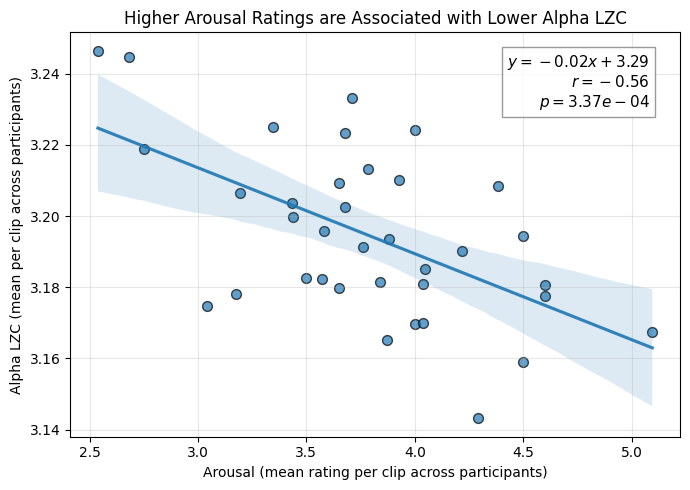

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Per-video aggregation for an easy-to-read scatter plot:
# mean alpha_mean and mean Arousal per clip
# Using combined_per_video_df which already has outliers removed
video_alpha_df = combined_per_video_df[['Video_ID', 'Arousal_mean', 'alpha_mean', 'N_participants']].copy()

# Rename alpha_mean to alpha_mean_per_video for consistency
video_alpha_df = video_alpha_df.rename(columns={
    "alpha_mean": "alpha_mean_per_video"
})

# 6. Clip-level correlation and linear regression between mean alpha LZC and mean arousal
x = video_alpha_df["Arousal_mean"]
y = video_alpha_df["alpha_mean_per_video"]
r, p_corr = pearsonr(x, y)
reg = linregress(x, y)

# Equation for the regression line for annotation
slope = reg.slope
intercept = reg.intercept

# Annotation text with p in scientific notation
eqn_text = (f"$y = {slope:.2f}x {intercept:+.2f}$\n"
            f"$r = {r:.2f}$\n"
            f"$p = {p_corr:.2e}$")

# 7. Plot: per-video Arousal_mean vs alpha_mean with regression line + annotation
plt.figure(figsize=(7, 5))
ax = sns.regplot(
    x="Arousal_mean",
    y="alpha_mean_per_video",
    data=video_alpha_df,
    scatter_kws=dict(alpha=0.7, s=50, edgecolor="black"),
    line_kws=dict(alpha=0.9)
)
plt.xlabel("Arousal (mean rating per clip across participants)")
plt.ylabel("Alpha LZC (mean per clip across participants)")
plt.title("Higher Arousal Ratings are Associated with Lower Alpha LZC")
plt.grid(alpha=0.3)
# Place annotation in upper right, but adapt location to data range
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
x_annot = x_max - 0.05 * (x_max - x_min)
y_annot = y_max - 0.05 * (y_max - y_min)
plt.text(x_annot, y_annot, eqn_text, ha='right', va='top', fontsize=11,
         bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.tight_layout()
plt.show()